# Credit Card Fraud Detection - EDA & Feature Engineering
Complete exploratory analysis and feature creation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [4]:
# Load data
df = pd.read_csv('creditcard.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [7]:
df.shape

(1296675, 23)

In [9]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [11]:
df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [12]:
df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [ ]:
df['is_fraud'].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [15]:
df['is_fraud'].value_counts(normalize=True) * 100

is_fraud
0    99.421135
1     0.578865
Name: proportion, dtype: float64

In [17]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['dayofweek'] = df['trans_date_trans_time'].dt.dayofweek


In [23]:
df.groupby('hour')['is_fraud'].count().sort_values(ascending=False)


hour
23    67104
22    66982
18    66051
16    65726
21    65533
19    65508
17    65450
15    65391
13    65314
12    65257
20    65098
14    64885
1     42869
3     42769
2     42656
8     42505
0     42502
6     42300
10    42271
7     42203
9     42185
5     42171
11    42082
4     41863
Name: is_fraud, dtype: int64

In [24]:
df.groupby('dayofweek')['is_fraud'].count().sort_values(ascending=False)

dayofweek
0    254282
6    250579
5    200957
1    160227
4    152272
3    147285
2    131073
Name: is_fraud, dtype: int64

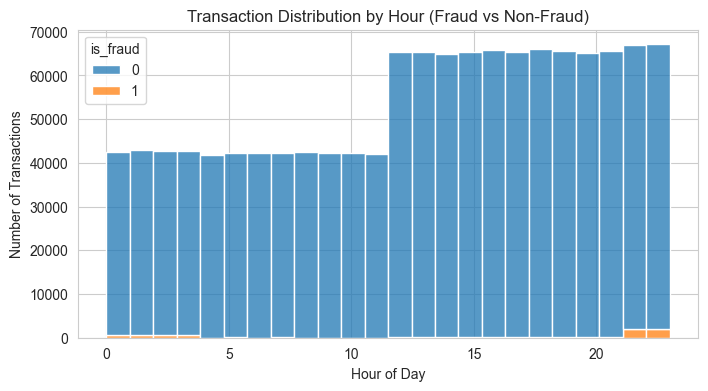

In [29]:
plt.figure(figsize=(8,4))

sns.histplot(data=df, x='hour', hue='is_fraud', multiple='stack', bins=24)

plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.title('Transaction Distribution by Hour (Fraud vs Non-Fraud)')
plt.show()

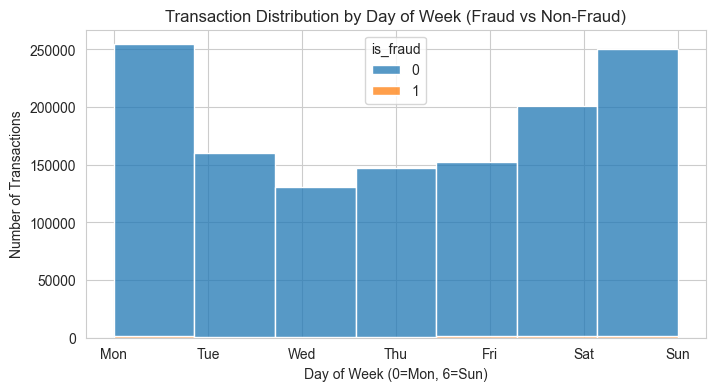

In [40]:
plt.figure(figsize=(8,4))

sns.histplot(data=df, x='dayofweek', hue='is_fraud', multiple='stack', bins=7)

plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.xticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Number of Transactions')
plt.title('Transaction Distribution by Day of Week (Fraud vs Non-Fraud)')
plt.show()


In [35]:
df.groupby('is_fraud')['amt'].describe()


,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,1289169.0,67.667110,154.007971,1.00,9.6100,47.280,82.540,28948.90
1,7506.0,531.320092,390.560070,1.06,245.6625,396.505,900.875,1376.04


## 4. Temporal Analysis

## 5. Category & Merchant Analysis

Top Categories by Fraud Rate:
               fraud_count  fraud_rate
category                              
shopping_net          1713    0.017561
misc_net               915    0.014458
grocery_pos           1743    0.014098
shopping_pos           843    0.007225
gas_transport          618    0.004694
misc_pos               250    0.003139
grocery_net            134    0.002948
travel                 116    0.002864
entertainment          233    0.002478
personal_care          220    0.002424


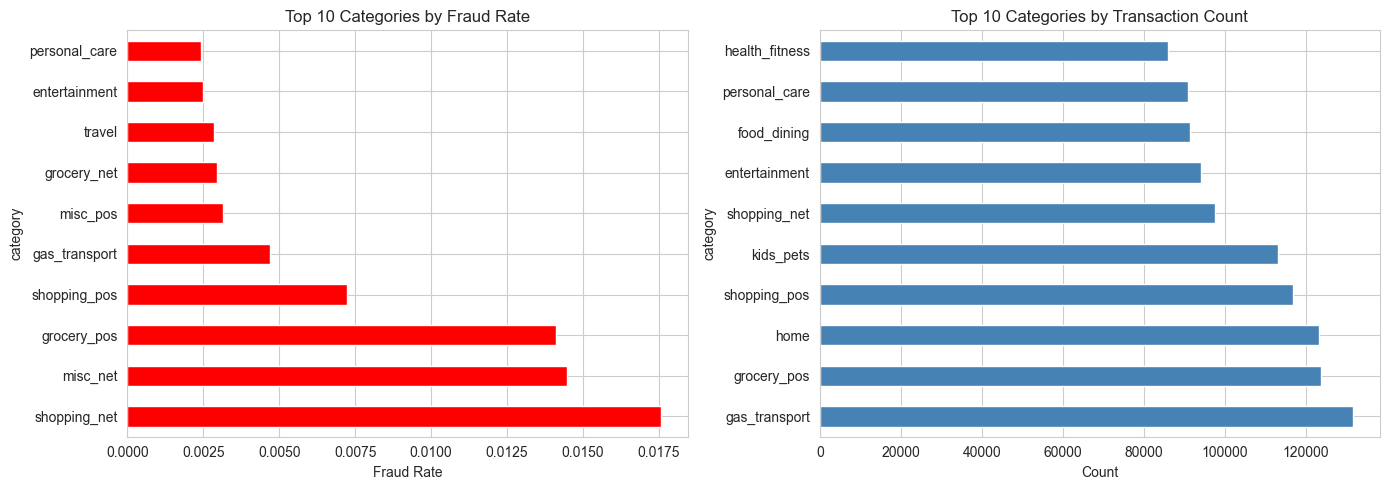

In [44]:
# Category analysis
fraud_by_category = df.groupby('category')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
fraud_by_category['fraud_count'] = fraud_by_category['sum']
fraud_by_category['fraud_rate'] = fraud_by_category['mean']

print("Top Categories by Fraud Rate:")
print(fraud_by_category[['fraud_count', 'fraud_rate']].head(10))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fraud rate by category
fraud_by_category['fraud_rate'].head(10).plot(kind='barh', ax=axes[0], color='red')
axes[0].set_title('Top 10 Categories by Fraud Rate')
axes[0].set_xlabel('Fraud Rate')

# Transaction count by category
df['category'].value_counts().head(10).plot(kind='barh', ax=axes[1], color='steelblue')
axes[1].set_title('Top 10 Categories by Transaction Count')
axes[1].set_xlabel('Count')

plt.tight_layout()
plt.show()

## 6. Geographic Analysis

Distance Statistics:
              count       mean        std       min        25%        50%  \
is_fraud                                                                    
0         1289169.0  84.987332  31.609032  0.026492  62.708948  88.613672   
1            7506.0  85.168223  31.270703  0.739037  62.960890  88.458663   

                 75%         max  
is_fraud                          
0         108.507085  156.883442  
1         108.379791  155.477148  


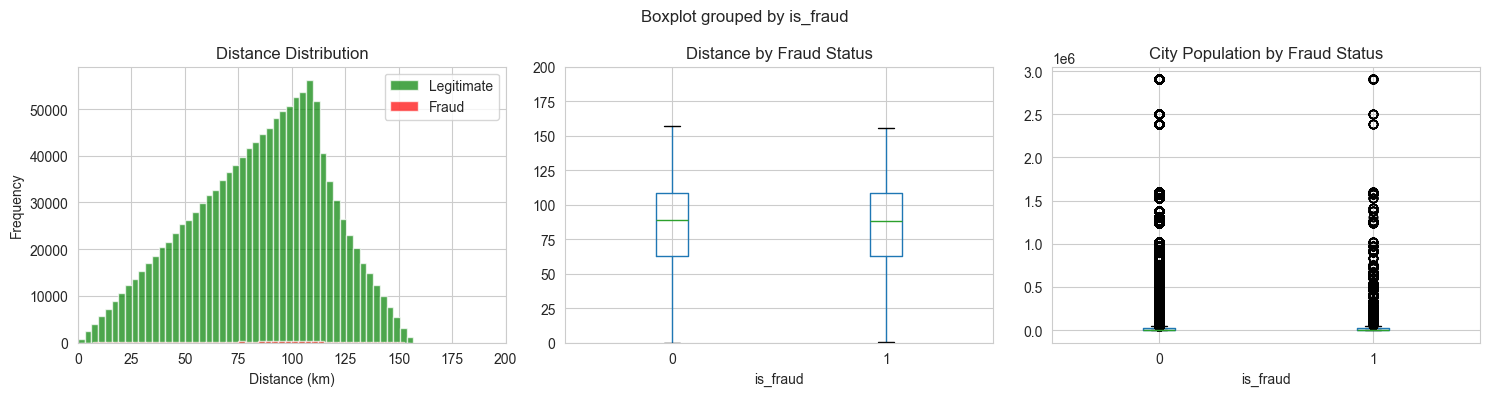

In [45]:
# Calculate distance
df['distance'] = np.sqrt(
    (df['lat'] - df['merch_lat'])**2 + 
    (df['long'] - df['merch_long'])**2
) * 111  # Convert to km

print("Distance Statistics:")
print(df.groupby('is_fraud')['distance'].describe())

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Distance distribution
df[df['is_fraud']==0]['distance'].hist(bins=50, ax=axes[0], alpha=0.7, label='Legitimate', color='green')
df[df['is_fraud']==1]['distance'].hist(bins=50, ax=axes[0], alpha=0.7, label='Fraud', color='red')
axes[0].set_xlabel('Distance (km)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distance Distribution')
axes[0].legend()
axes[0].set_xlim(0, 200)

# Box plot
df.boxplot(column='distance', by='is_fraud', ax=axes[1])
axes[1].set_title('Distance by Fraud Status')
axes[1].set_ylim(0, 200)

# City population
df.boxplot(column='city_pop', by='is_fraud', ax=axes[2])
axes[2].set_title('City Population by Fraud Status')

plt.tight_layout()
plt.show()

## 7. Feature Engineering

In [46]:
def create_features(df):
    """Create all engineered features"""
    df = df.copy()
    
    print("Creating features...")
    
    # 1. TIME FEATURES
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
    df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)
    
    # 2. AMOUNT FEATURES
    df['amt_log'] = np.log1p(df['amt'])
    df['amt_sqrt'] = np.sqrt(df['amt'])
    
    # 3. DISTANCE
    df['distance'] = np.sqrt(
        (df['lat'] - df['merch_lat'])**2 + 
        (df['long'] - df['merch_long'])**2
    ) * 111
    df['distance_log'] = np.log1p(df['distance'])
    
    # 4. AGE
    df['dob'] = pd.to_datetime(df['dob'])
    df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days / 365.25
    
    # 5. BEHAVIORAL FEATURES
    df = df.sort_values(['cc_num', 'unix_time'])
    
    # Time since last transaction
    df['time_diff'] = df.groupby('cc_num')['unix_time'].diff()
    df['time_diff'] = df['time_diff'].fillna(86400)
    df['time_diff_log'] = np.log1p(df['time_diff'])
    
    # Transaction velocity
    df['trans_count_3'] = df.groupby('cc_num')['unix_time'].transform(
        lambda x: x.rolling(window=3, min_periods=1).count()
    )
    df['trans_count_10'] = df.groupby('cc_num')['unix_time'].transform(
        lambda x: x.rolling(window=10, min_periods=1).count()
    )
    
    # Amount aggregations
    df['amt_sum_3'] = df.groupby('cc_num')['amt'].transform(
        lambda x: x.rolling(window=3, min_periods=1).sum()
    )
    df['amt_sum_10'] = df.groupby('cc_num')['amt'].transform(
        lambda x: x.rolling(window=10, min_periods=1).sum()
    )
    
    # Average amount per card
    df['avg_amt'] = df.groupby('cc_num')['amt'].transform('mean')
    df['std_amt'] = df.groupby('cc_num')['amt'].transform('std')
    df['amt_vs_avg'] = df['amt'] / (df['avg_amt'] + 1)
    df['amt_zscore'] = (df['amt'] - df['avg_amt']) / (df['std_amt'] + 1)
    
    # 6. CATEGORY & MERCHANT
    df['category_encoded'] = pd.factorize(df['category'])[0]
    df['merchant_freq'] = df.groupby(['cc_num', 'merchant'])['merchant'].transform('count')
    df['category_freq'] = df.groupby(['cc_num', 'category'])['category'].transform('count')
    
    # 7. RISK FLAGS
    df['high_amount'] = (df['amt'] > 200).astype(int)
    df['very_high_amount'] = (df['amt'] > 500).astype(int)
    df['rapid_trans'] = (df['time_diff'] < 300).astype(int)
    df['far_distance'] = (df['distance'] > 50).astype(int)
    df['very_far_distance'] = (df['distance'] > 100).astype(int)
    df['unusual_amount'] = (df['amt_vs_avg'] > 3).astype(int)
    
    # 8. INTERACTION FEATURES
    df['amt_hour'] = df['amt'] * df['hour']
    df['distance_amt'] = df['distance'] * df['amt']
    df['weekend_night'] = df['is_weekend'] * df['is_night']
    
    # 9. CITY FEATURES
    df['city_pop_log'] = np.log1p(df['city_pop'])
    df['is_urban'] = (df['city_pop'] > 100000).astype(int)
    
    print(f"Features created! New shape: {df.shape}")
    return df

# Create features
df_features = create_features(df)

# Show new columns
new_cols = [col for col in df_features.columns if col not in df.columns]
print(f"\nNew features created ({len(new_cols)}):")
print(new_cols)

Creating features...
Features created! New shape: (1296675, 59)

New features created (31):
['is_weekend', 'is_night', 'is_business_hours', 'amt_log', 'amt_sqrt', 'distance_log', 'age', 'time_diff', 'time_diff_log', 'trans_count_3', 'trans_count_10', 'amt_sum_3', 'amt_sum_10', 'avg_amt', 'std_amt', 'amt_vs_avg', 'amt_zscore', 'category_encoded', 'merchant_freq', 'category_freq', 'high_amount', 'very_high_amount', 'rapid_trans', 'far_distance', 'very_far_distance', 'unusual_amount', 'amt_hour', 'distance_amt', 'weekend_night', 'city_pop_log', 'is_urban']


## 8. Feature Correlation Analysis

Top 15 Features Correlated with Fraud:
is_fraud          1.000000
amt_sum_3         0.317336
amt_sum_10        0.313435
high_amount       0.254827
unusual_amount    0.247345
amt_zscore        0.244489
amt               0.219404
avg_amt           0.209960
amt_vs_avg        0.196245
amt_log           0.120439
is_night          0.086566
rapid_trans       0.029967
hour              0.013799
age               0.012270
is_urban          0.004144
Name: is_fraud, dtype: float64


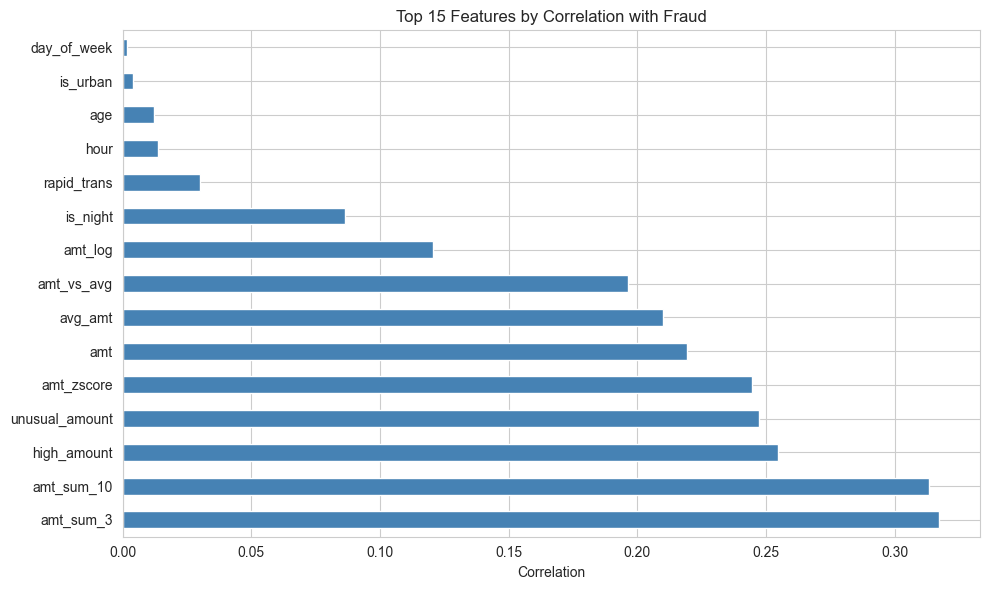

In [47]:
# Select numerical features for correlation
feature_cols = [
    'hour', 'day_of_week', 'is_weekend', 'is_night', 'is_business_hours',
    'amt', 'amt_log', 'distance', 'distance_log', 'age',
    'time_diff', 'time_diff_log', 'trans_count_3', 'trans_count_10',
    'amt_sum_3', 'amt_sum_10', 'avg_amt', 'amt_vs_avg', 'amt_zscore',
    'category_encoded', 'merchant_freq', 'category_freq',
    'high_amount', 'rapid_trans', 'far_distance', 'unusual_amount',
    'city_pop_log', 'is_urban', 'is_fraud'
]

# Correlation with target
correlations = df_features[feature_cols].corr()['is_fraud'].sort_values(ascending=False)
print("Top 15 Features Correlated with Fraud:")
print(correlations.head(15))

# Plot
plt.figure(figsize=(10, 6))
correlations[1:16].plot(kind='barh', color='steelblue')
plt.title('Top 15 Features by Correlation with Fraud')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

## 9. Save Processed Data

In [49]:
# Define final feature columns
FEATURE_COLS = [
    'hour', 'day_of_week', 'is_weekend', 'is_night', 'is_business_hours',
    'amt', 'amt_log', 'amt_sqrt',
    'distance', 'distance_log',
    'age',
    'time_diff', 'time_diff_log', 'trans_count_3', 'trans_count_10',
    'amt_sum_3', 'amt_sum_10',
    'avg_amt', 'std_amt', 'amt_vs_avg', 'amt_zscore',
    'category_encoded', 'merchant_freq', 'category_freq',
    'high_amount', 'very_high_amount', 'rapid_trans', 
    'far_distance', 'very_far_distance', 'unusual_amount',
    'amt_hour', 'distance_amt', 'weekend_night',
    'city_pop_log', 'is_urban'
]

# Save processed data
df_features.to_csv('processed_transactions.csv', index=False)
print(f"Processed data saved!")
print(f"Shape: {df_features.shape}")
print(f"Features for modeling: {len(FEATURE_COLS)}")

Processed data saved!
Shape: (1296675, 59)
Features for modeling: 35


## 10. Summary Statistics

In [ ]:
print("=" * 60)
print("EDA & FEATURE ENGINEERING SUMMARY")
print("=" * 60)

print(f"\n📊 Dataset Overview:")
print(f"  Total Transactions: {len(df_features):,}")
print(f"  Fraud Transactions: {df_features['is_fraud'].sum():,}")
print(f"  Fraud Rate: {df_features['is_fraud'].mean():.2%}")

print(f"\n💰 Amount Insights:")
print(f"  Avg Legitimate: ${df_features[df_features['is_fraud']==0]['amt'].mean():.2f}")
print(f"  Avg Fraud: ${df_features[df_features['is_fraud']==1]['amt'].mean():.2f}")

print(f"\n⏰ Time Insights:")
print(f"  Peak Fraud Hour: {fraud_by_hour['mean'].idxmax()}")
print(f"  Peak Fraud Rate: {fraud_by_hour['mean'].max():.2%}")

print(f"\n📍 Distance Insights:")
print(f"  Avg Distance (Legit): {df_features[df_features['is_fraud']==0]['distance'].mean():.1f} km")
print(f"  Avg Distance (Fraud): {df_features[df_features['is_fraud']==1]['distance'].mean():.1f} km")

print(f"\n🏆 Top Risky Categories:")
for cat, rate in fraud_by_category['fraud_rate'].head(3).items():
    print(f"  {cat}: {rate:.2%}")

print(f"\n✅ Features Created: {len(FEATURE_COLS)}")
print(f"\n📁 Data saved to: processed_transactions.csv")
print(f"\nReady for modeling! 🚀")

EDA & FEATURE ENGINEERING SUMMARY

📊 Dataset Overview:
  Total Transactions: 1,296,675
  Fraud Transactions: 7,506
  Fraud Rate: 0.58%

💰 Amount Insights:
  Avg Legitimate: $67.67
  Avg Fraud: $531.32

⏰ Time Insights:
  Peak Fraud Hour: 22
  Peak Fraud Rate: 2.88%

📍 Distance Insights:
  Avg Distance (Legit): 85.0 km
  Avg Distance (Fraud): 85.2 km

🏆 Top Risky Categories:
  shopping_net: 1.76%
  misc_net: 1.45%
  grocery_pos: 1.41%

✅ Features Created: 35

📁 Data saved to: data/processed_transactions.csv

Ready for modeling! 🚀


In [51]:
df = pd.read_csv('processed_transactions.csv')

In [52]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,very_high_amount,rapid_trans,far_distance,very_far_distance,unusual_amount,amt_hour,distance_amt,weekend_night,city_pop_log,is_urban
0,1017,2019-01-01 12:47:15,60416207185,"fraud_Jones, Sawayn and Romaguera",misc_net,7.27,Mary,Diaz,F,9886 Anita Drive,...,0,0,1,1,0,87.24,1038.330642,0,7.406103,0
1,2724,2019-01-02 08:44:57,60416207185,fraud_Berge LLC,gas_transport,52.94,Mary,Diaz,F,9886 Anita Drive,...,0,0,1,1,0,423.52,5858.978012,0,7.406103,0
2,2726,2019-01-02 08:47:36,60416207185,fraud_Luettgen PLC,gas_transport,82.08,Mary,Diaz,F,9886 Anita Drive,...,0,1,0,0,0,656.64,2412.161893,0,7.406103,0
3,2882,2019-01-02 12:38:14,60416207185,fraud_Daugherty LLC,kids_pets,34.79,Mary,Diaz,F,9886 Anita Drive,...,0,0,1,0,0,417.48,3053.379384,0,7.406103,0
4,2907,2019-01-02 13:10:46,60416207185,fraud_Beier and Sons,home,27.18,Mary,Diaz,F,9886 Anita Drive,...,0,0,1,0,0,353.34,2610.852324,0,7.406103,0
